<a href="https://colab.research.google.com/github/writezubair-cpu/ZAK-TEST_AI_Training/blob/main/Copy_of_EDA_powerplant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Create a step-by-step EDA script with clearly separated sections and comments.
# This produces a runnable Python file you can execute as-is (e.g., "python eda_step_by_step.py")
# or copy-paste cell by cell into Colab/Jupyter.

import textwrap, os, json, pathlib


# -*- coding: utf-8 -*-
"""
Step-by-step EDA for: /mnt/data/power_plant_database_global.csv

How to use:
- Run the whole script OR execute section-by-section in a notebook.
- Each step is self-contained with comments and minimal dependencies.
- Plots use matplotlib only (no seaborn) with one chart per figure as requested.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype
from pandas.plotting import scatter_matrix

# -----------------------------
# STEP 0: Load the dataset
# -----------------------------
def step0_load_csv(path="/content/power_plant_database_global.csv"):
    """
    Load CSV robustly by trying common encodings.
    Returns the loaded DataFrame.
    """
    encodings_to_try = ["utf-8", "utf-8-sig", "latin1"]
    last_err = None
    for enc in encodings_to_try:
        try:
            df = pd.read_csv(path, encoding=enc, low_memory=False)
            print(f"[OK] Loaded file with encoding: {enc}")
            return df
        except Exception as e:
            last_err = e
    raise last_err

# -----------------------------
# STEP 1: Basic shape & memory
# -----------------------------
def step1_shape_and_memory(df):
    """
    Print basic dimensionality and approximate memory usage.
    """
    n_rows, n_cols = df.shape
    mem_mb = df.memory_usage(deep=True).sum() / (1024 * 1024)
    print(f"[INFO] Shape: {n_rows:,} rows × {n_cols:,} columns")
    print(f"[INFO] Approx. memory usage: {mem_mb:.2f} MB")

# -----------------------------
# STEP 2: Preview head & tail
# -----------------------------
def step2_preview(df, n=5):
    """
    Show first and last N rows.
    """
    print("\n[HEAD] First rows:"); print(df.head(n))
    print("\n[TAIL] Last rows:"); print(df.tail(n))

# -----------------------------
# STEP 3: Dtypes & Missingness
# -----------------------------
def step3_schema_missingness(df):
    """
    Build a schema table with dtype, non-null counts, null pct, unique counts, and ID-like heuristic.
    Returns the summary DataFrame.
    """
    schema = pd.DataFrame({
        "column": df.columns,
        "dtype": [str(t) for t in df.dtypes],
        "non_null_count": df.notna().sum().values,
        "null_count": df.isna().sum().values
    })
    schema["null_pct"] = (schema["null_count"] / len(df) * 100).round(2)
    schema["n_unique"] = [df[c].nunique(dropna=True) for c in df.columns]
    schema["id_like"] = (schema["n_unique"] / max(1, len(df)) > 0.95)
    print("\n[SCHEMA & MISSINGNESS]\n", schema.sort_values("null_pct", ascending=False))
    return schema

# -----------------------------
# STEP 4: Parse datetime columns (heuristic)
# -----------------------------
def step4_parse_datetimes(df):
    """
    Heuristically parse columns whose names contain 'date' or 'time' into datetimes (if parseable).
    Returns a list of columns successfully parsed.
    """
    parsed = []
    for c in df.columns:
        if "date" in c.lower() or "time" in c.lower():
            try:
                df[c] = pd.to_datetime(df[c], errors="raise", infer_datetime_format=True)
                parsed.append(c)
            except Exception:
                pass
    if parsed:
        print(f"[INFO] Parsed as datetime: {parsed}")
    else:
        print("[INFO] No datetime columns parsed.")
    return parsed

# -----------------------------
# STEP 5: Identify numeric / datetime / categorical columns
# -----------------------------
def step5_split_types(df):
    """
    Separate columns by type for downstream analysis.
    Returns (numeric_cols, datetime_cols, categorical_cols).
    """
    numeric_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
    datetime_cols = [c for c in df.columns if is_datetime64_any_dtype(df[c])]
    categorical_cols = [c for c in df.columns if c not in numeric_cols and c not in datetime_cols]
    print(f"[INFO] Numeric columns   ({len(numeric_cols)}): {numeric_cols}")
    print(f"[INFO] Datetime columns  ({len(datetime_cols)}): {datetime_cols}")
    print(f"[INFO] Categorical cols  ({len(categorical_cols)}): {categorical_cols[:20]}{'...' if len(categorical_cols)>20 else ''}")
    return numeric_cols, datetime_cols, categorical_cols

# -----------------------------
# STEP 6: Duplicates
# -----------------------------
def step6_duplicates(df):
    """
    Count duplicate rows.
    """
    dup_count = df.duplicated().sum()
    pct = (dup_count / len(df) * 100) if len(df) else 0
    print(f"[INFO] Duplicate rows: {dup_count:,} ({pct:.2f}%)")
    return dup_count

# -----------------------------
# STEP 7: Numeric summary (describe + missingness)
# -----------------------------
def step7_numeric_summary(df, numeric_cols):
    """
    Describe numeric columns and add missingness stats.
    Returns the numeric summary DataFrame.
    """
    if not numeric_cols:
        print("[WARN] No numeric columns.")
        return pd.DataFrame()
    summary = df[numeric_cols].describe().T
    summary["missing"] = df[numeric_cols].isna().sum()
    summary["missing_pct"] = (df[numeric_cols].isna().sum() / len(df) * 100).round(2)
    print("\n[NUMERIC SUMMARY]\n", summary)
    return summary

# -----------------------------
# STEP 8: Categorical value counts (Top-K)
# -----------------------------
def step8_categorical_vc(df, categorical_cols, topk=10):
    """
    Show top-K value counts for each categorical column.
    Returns a dict: {column -> DataFrame of top value counts}.
    """
    results = {}
    for c in categorical_cols:
        vc = df[c].astype("object").value_counts(dropna=False).head(topk)
        results[c] = vc.rename_axis("value").reset_index(name="count")
        print(f"\n[CATEGORICAL TOP {topk}] {c}\n", results[c])
    return results

# -----------------------------
# STEP 9: Outlier analysis (IQR)
# -----------------------------
def step9_outliers_iqr(df, numeric_cols):
    """
    Compute IQR-based outlier count per numeric column.
    Returns a summary DataFrame with bounds and outlier counts.
    """
    rows = []
    for c in numeric_cols:
        series = df[c].dropna()
        if series.empty:
            continue
        q1, q3 = np.percentile(series, [25, 75])
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = ((df[c] < lower) | (df[c] > upper)).sum()
        pct = (outliers / len(df) * 100) if len(df) else 0
        rows.append({
            "column": c, "Q1": q1, "Q3": q3, "IQR": iqr,
            "lower_bound": lower, "upper_bound": upper,
            "outlier_count": int(outliers), "outlier_pct": round(pct, 2)
        })
    out_df = pd.DataFrame(rows).sort_values("outlier_pct", ascending=False)
    print("\n[OUTLIER SUMMARY]\n", out_df)
    return out_df

# -----------------------------
# STEP 10: Correlation matrix & heatmap (numeric only)
# -----------------------------
def step10_corr_heatmap(df, numeric_cols, save_path=None):
    """
    Compute correlation matrix for numeric columns and plot heatmap.
    Optionally save matrix to CSV.
    """
    if len(numeric_cols) < 2:
        print("[INFO] Not enough numeric columns for correlation.")
        return None
    corr = df[numeric_cols].corr(numeric_only=True)
    if save_path:
        corr.to_csv(save_path, index=True)
        print(f"[FILE] Correlation matrix saved: {save_path}")
    # Heatmap plot
    plt.figure(figsize=(max(6, min(0.5 * len(numeric_cols) + 2, 18)),
                        max(5, min(0.5 * len(numeric_cols) + 2, 18))))
    plt.imshow(corr.values, interpolation='nearest', aspect='auto')
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.xticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols, rotation=90)
    plt.yticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    return corr

# -----------------------------
# STEP 11: Histograms for top numeric columns (by non-null count)
# -----------------------------
def step11_histograms(df, numeric_cols, max_plots=8, bins=30):
    """
    Plot histograms for up to 'max_plots' numeric columns with the most non-null values.
    """
    if not numeric_cols:
        print("[INFO] No numeric columns to plot.")
        return
    non_null_counts = df[numeric_cols].notna().sum().sort_values(ascending=False)
    top_numeric = list(non_null_counts.index[:max_plots])
    for c in top_numeric:
        plt.figure(figsize=(7, 4))
        plt.hist(df[c].dropna(), bins=bins)
        plt.title(f"Histogram of {c}")
        plt.xlabel(c); plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# -----------------------------
# STEP 12: Scatter matrix (first K numeric columns)
# -----------------------------
def step12_scatter_matrix(df, numeric_cols, k=5):
    """
    Create a scatter matrix for the first K numeric columns.
    """
    if len(numeric_cols) < 2:
        print("[INFO] Not enough numeric columns for scatter matrix.")
        return
    cols = numeric_cols[:k]
    plt.figure(figsize=(10, 10))
    scatter_matrix(df[cols].dropna(), diagonal='hist', figsize=(10, 10))
    plt.suptitle("Scatter Matrix (First {} Numeric Columns)".format(len(cols)))
    plt.tight_layout()
    plt.show()

# -----------------------------
# STEP 13: Save EDA artifacts
# -----------------------------
def step13_save_artifacts(schema_df, numeric_summary, outlier_df, corr_df):
    """
    Save EDA tables to CSVs for downstream analysis/sharing.
    """
    paths = {}
    if schema_df is not None and not schema_df.empty:
        paths["column_summary"] = "/content/eda_column_summary.csv"
        schema_df.to_csv(paths["column_summary"], index=False)
    if numeric_summary is not None and not numeric_summary.empty:
        paths["numeric_summary"] = "/content/numeric_summary.csv"
        numeric_summary.to_csv(paths["numeric_summary"])
    if outlier_df is not None and not outlier_df.empty:
        paths["outlier_summary"] = "/content/outlier_summary.csv"
        outlier_df.to_csv(paths["outlier_summary"], index=False)
    if corr_df is not None and isinstance(corr_df, pd.DataFrame) and not corr_df.empty:
        paths["correlation_matrix"] = "/content/correlation_matrix.csv"
        corr_df.to_csv(paths["correlation_matrix"])
    print("\n[FILES SAVED]")
    for k, v in paths.items():
        print(f"- {k}: {v}")
    return paths







In [ ]:
country_power_output = df.groupby('country')['total_gen_gwh'].sum().sort_values(ascending=False)
display(country_power_output.head(20))

,total_gen_gwh
country,
USA,2.527632e+07
IND,5.329763e+06
FRA,1.194339e+06
AUS,1.153056e+06
DEU,8.846659e+05
ITA,3.800154e+05
ESP,3.581240e+05
POL,3.365298e+05
SWE,1.574369e+05


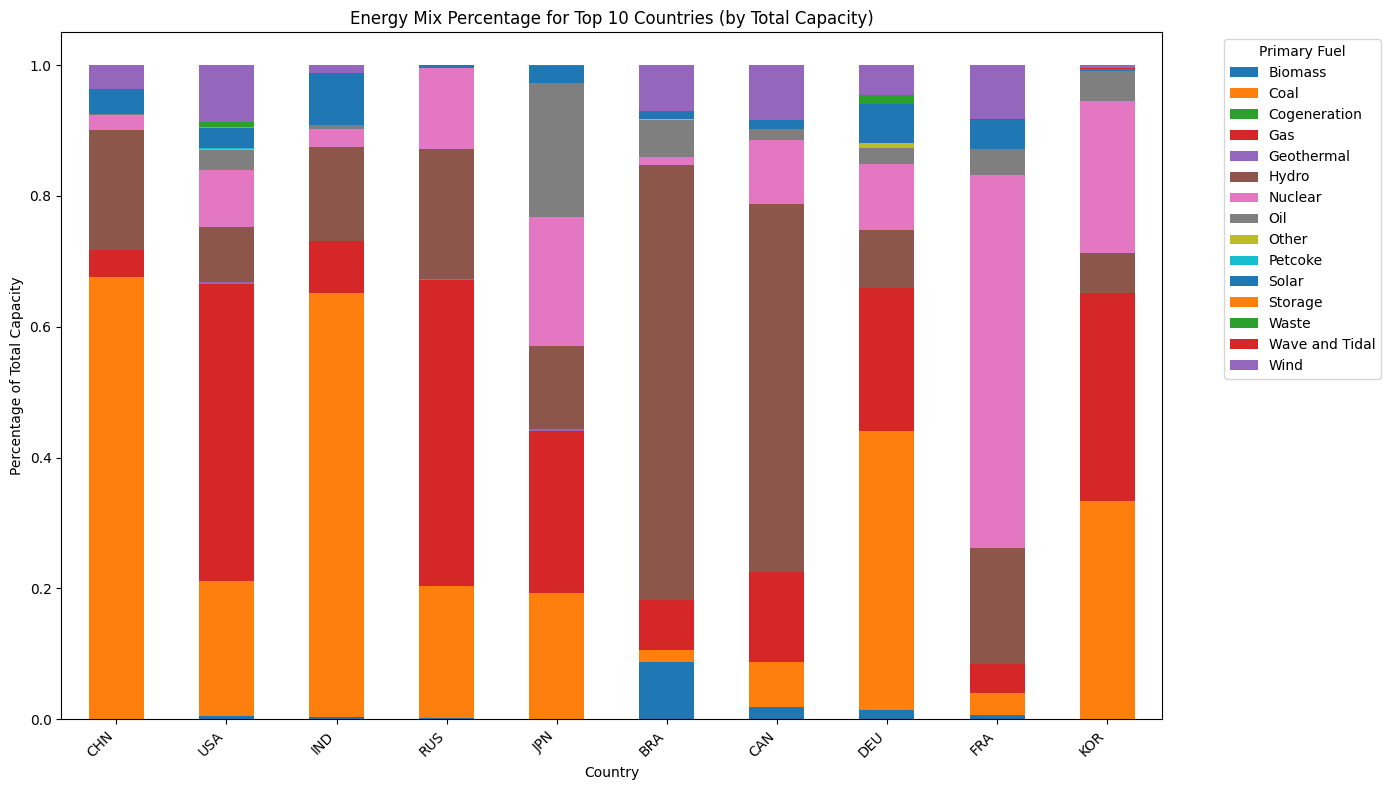

In [ ]:
# Calculate total capacity per country to identify top countries
total_capacity_per_country = df.groupby('country')['capacity_mw'].sum().sort_values(ascending=False)
top_10_countries = total_capacity_per_country.head(10).index.tolist()

# Filter the percentage energy mix for the top 10 countries
top_10_energy_mix_pct = country_energy_mix_pct.loc[top_10_countries]

# Plotting the stacked bar chart
plt.figure(figsize=(14, 8))
top_10_energy_mix_pct.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Energy Mix Percentage for Top 10 Countries (by Total Capacity)')
plt.xlabel('Country')
plt.ylabel('Percentage of Total Capacity')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Primary Fuel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
country_energy_mix = df.groupby(['country', 'primary_fuel'])['capacity_mw'].sum().unstack(fill_value=0)
display(country_energy_mix.head())

primary_fuel,Biomass,Coal,Cogeneration,Gas,Geothermal,Hydro,Nuclear,Oil,Other,Petcoke,Solar,Storage,Waste,Wave and Tidal,Wind
country,,,,,,,,,,,,,,,
AFG,0.0,0.0,0.0,42.00,0.0,238.55,0.0,0.000,0.00,0.0,20.0,0.0,0.0,0.0,0.00
AGO,0.0,0.0,0.0,163.68,0.0,770.60,0.0,136.900,0.00,0.0,0.0,0.0,0.0,0.0,0.00
ALB,0.0,0.0,0.0,0.00,0.0,1431.00,0.0,0.000,98.00,0.0,0.0,0.0,0.0,0.0,0.00
ARE,0.0,0.0,0.0,29487.00,0.0,0.00,0.0,0.000,0.00,0.0,840.0,0.0,0.0,0.0,0.00
ARG,0.0,4857.4,0.0,13041.84,0.0,9999.71,1763.0,1199.289,1324.46,0.0,515.7,0.0,0.0,0.0,211.68


This table shows the total capacity (in MW) for each primary fuel type within each country. To get a better sense of the energy mix within a country, we can normalize these values to show the percentage of each fuel type.

In [ ]:
country_energy_mix_pct = country_energy_mix.apply(lambda x: x / x.sum(), axis=1)
display(country_energy_mix_pct.head())

primary_fuel,Biomass,Coal,Cogeneration,Gas,Geothermal,Hydro,Nuclear,Oil,Other,Petcoke,Solar,Storage,Waste,Wave and Tidal,Wind
country,,,,,,,,,,,,,,,
AFG,0.0,0.000000,0.0,0.139744,0.0,0.793712,0.000000,0.000000,0.000000,0.0,0.066545,0.0,0.0,0.0,0.000000
AGO,0.0,0.000000,0.0,0.152803,0.0,0.719394,0.000000,0.127803,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
ALB,0.0,0.000000,0.0,0.000000,0.0,0.935906,0.000000,0.000000,0.064094,0.0,0.000000,0.0,0.0,0.0,0.000000
ARE,0.0,0.000000,0.0,0.972302,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.027698,0.0,0.0,0.0,0.000000
ARG,0.0,0.147583,0.0,0.396251,0.0,0.303822,0.053565,0.036438,0.040241,0.0,0.015669,0.0,0.0,0.0,0.006431


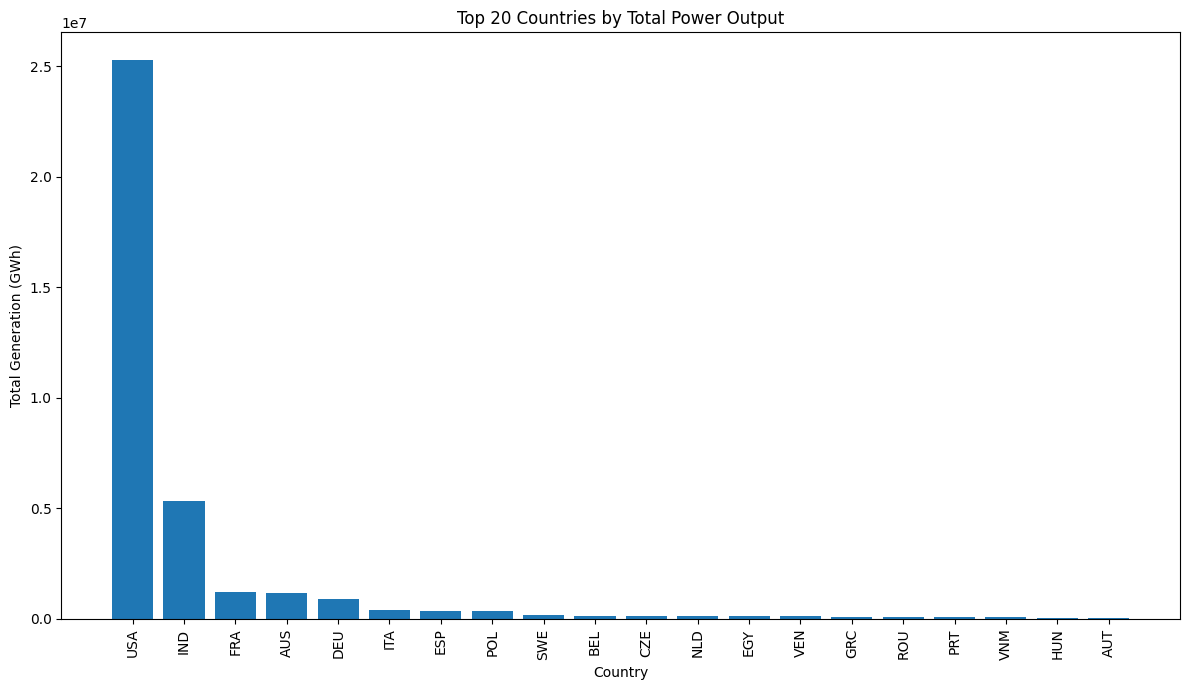

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.bar(country_power_output.head(20).index, country_power_output.head(20).values)
plt.xlabel('Country')
plt.ylabel('Total Generation (GWh)')
plt.title('Top 20 Countries by Total Power Output')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# MAIN (run all steps)
# -----------------------------
if __name__ == "__main__":
    df = step0_load_csv()
    step1_shape_and_memory(df)
    step2_preview(df, n=5)



[OK] Loaded file with encoding: utf-8
[INFO] Shape: 34,936 rows × 36 columns
[INFO] Approx. memory usage: 41.54 MB

[HEAD] First rows:
  country country_long                                              name  \
0     AFG  Afghanistan      Kajaki Hydroelectric Power Plant Afghanistan   
1     AFG  Afghanistan                                      Kandahar DOG   
2     AFG  Afghanistan                                      Kandahar JOL   
3     AFG  Afghanistan     Mahipar Hydroelectric Power Plant Afghanistan   
4     AFG  Afghanistan  Naghlu Dam Hydroelectric Power Plant Afghanistan   

      gppd_idnr  capacity_mw  latitude  longitude primary_fuel other_fuel1  \
0  GEODB0040538         33.0    32.322    65.1190        Hydro         NaN   
1    WKS0070144         10.0    31.670    65.7950        Solar         NaN   
2    WKS0071196         10.0    31.623    65.7920        Solar         NaN   
3  GEODB0040541         66.0    34.556    69.4787        Hydro         NaN   
4  GEODB0040534   

In [ ]:
schema_df = step3_schema_missingness(df)
step4_parse_datetimes(df)


[SCHEMA & MISSINGNESS]
                             column    dtype  non_null_count  null_count  \
10                     other_fuel3   object              92       34844   
9                      other_fuel2   object             276       34660   
8                      other_fuel1   object            1944       32992   
18             generation_gwh_2013  float64            6417       28519   
19             generation_gwh_2014  float64            7226       27710   
20             generation_gwh_2015  float64            8203       26733   
21             generation_gwh_2016  float64            9144       25792   
22             generation_gwh_2017  float64            9500       25436   
23             generation_gwh_2018  float64            9637       25299   
24             generation_gwh_2019  float64            9659       25277   
25          generation_data_source   object           11400       23536   
17           year_of_capacity_data  float64           14887       20049   


[]

In [ ]:
numeric_cols, datetime_cols, categorical_cols = step5_split_types(df)
step6_duplicates(df)
numeric_summary = step7_numeric_summary(df, numeric_cols)
cat_vc = step8_categorical_vc(df, categorical_cols, topk=10)

[INFO] Numeric columns   (17): ['capacity_mw', 'latitude', 'longitude', 'commissioning_year', 'year_of_capacity_data', 'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017', 'generation_gwh_2018', 'generation_gwh_2019', 'estimated_generation_gwh_2013', 'estimated_generation_gwh_2014', 'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016', 'estimated_generation_gwh_2017']
[INFO] Datetime columns  (0): []
[INFO] Categorical cols  (19): ['country', 'country_long', 'name', 'gppd_idnr', 'primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3', 'owner', 'source', 'url', 'geolocation_source', 'wepp_id', 'generation_data_source', 'estimated_generation_note_2013', 'estimated_generation_note_2014', 'estimated_generation_note_2015', 'estimated_generation_note_2016', 'estimated_generation_note_2017']
[INFO] Duplicate rows: 0 (0.00%)

[NUMERIC SUMMARY]
                                  count         mean          std        m


[OUTLIER SUMMARY]
                            column           Q1           Q3         IQR  \
16  estimated_generation_gwh_2017     8.180000   229.565000  221.385000   
0                     capacity_mw     4.900000    75.344250   70.444250   
1                        latitude    29.256475    46.263125   17.006650   
15  estimated_generation_gwh_2016     8.322500   107.237500   98.915000   
14  estimated_generation_gwh_2015     8.380000   103.120000   94.740000   
13  estimated_generation_gwh_2014     8.680000   106.980000   98.300000   
12  estimated_generation_gwh_2013     8.620000   106.805000   98.185000   
11            generation_gwh_2019     2.751500   122.781498  120.029999   
10            generation_gwh_2018     2.242000   151.117000  148.875000   
9             generation_gwh_2017     2.467000   214.505150  212.038150   
8             generation_gwh_2016     2.729000   249.866750  247.137750   
7             generation_gwh_2015     2.664500   285.862583  283.198083   
6    

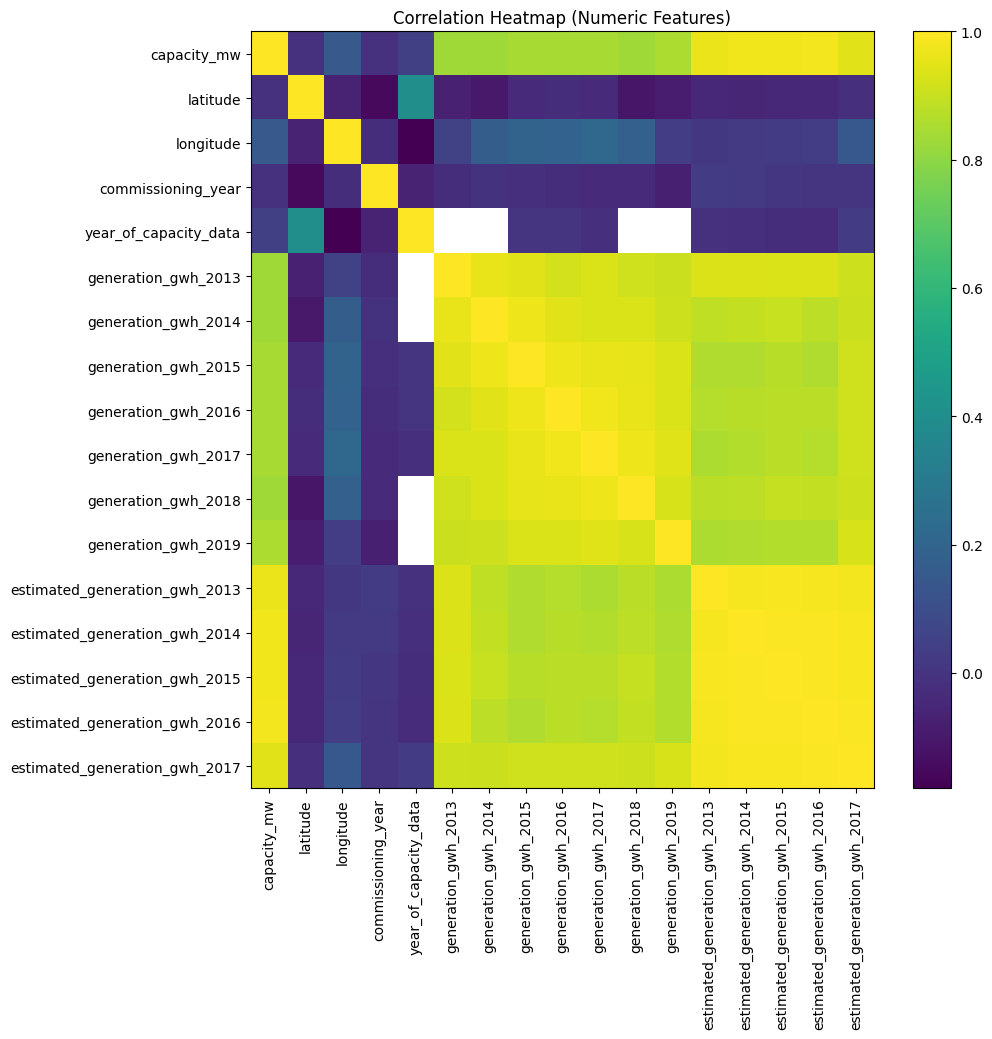

In [ ]:
outlier_df = step9_outliers_iqr(df, numeric_cols)
corr_df = step10_corr_heatmap(df, numeric_cols, save_path="/content/correlation_matrix.csv")

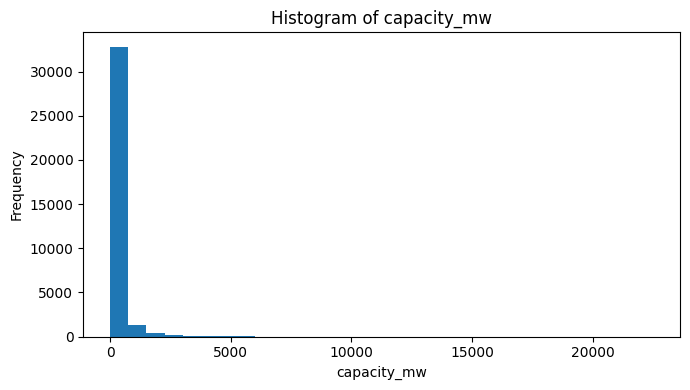

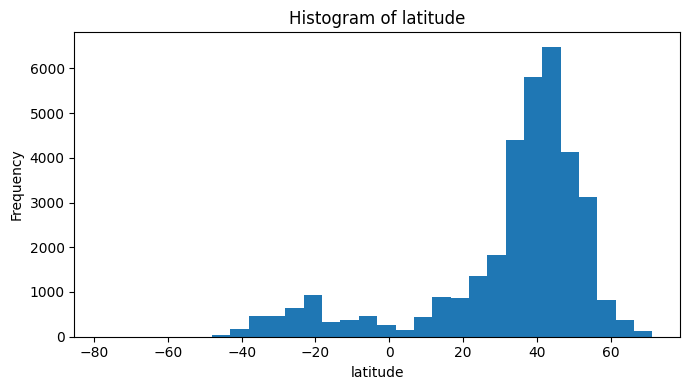

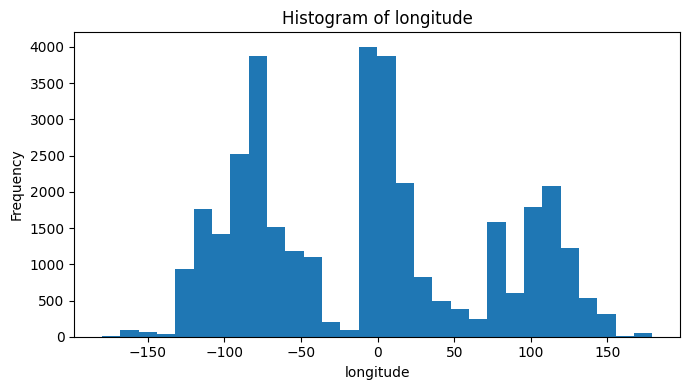

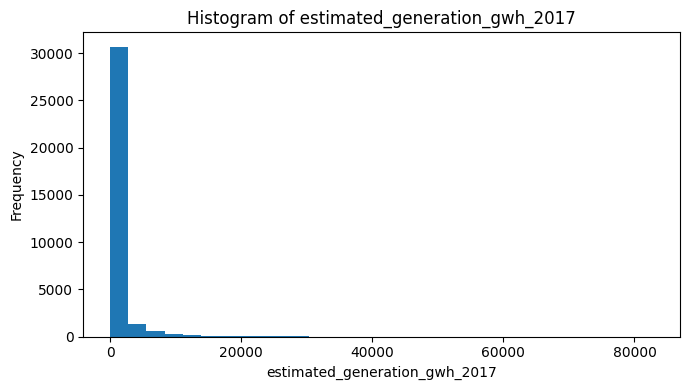

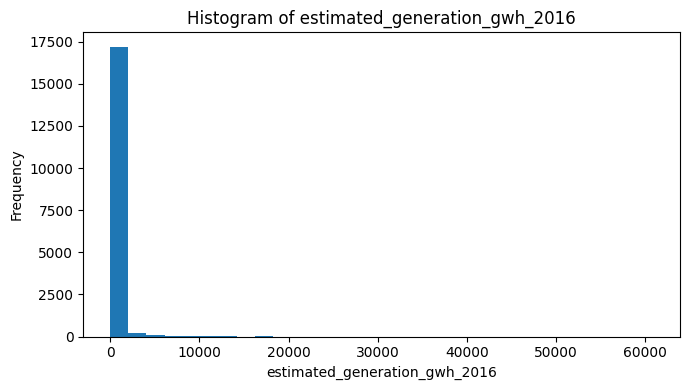

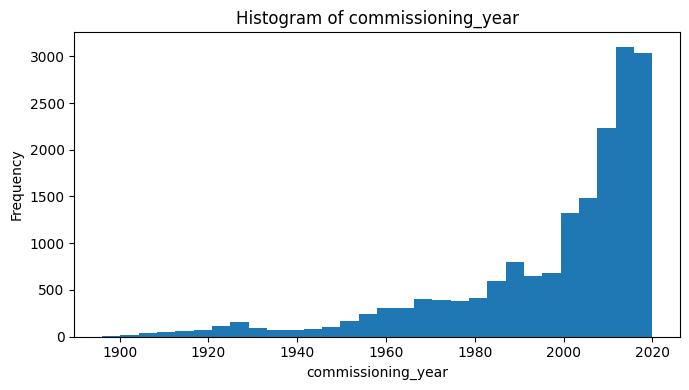

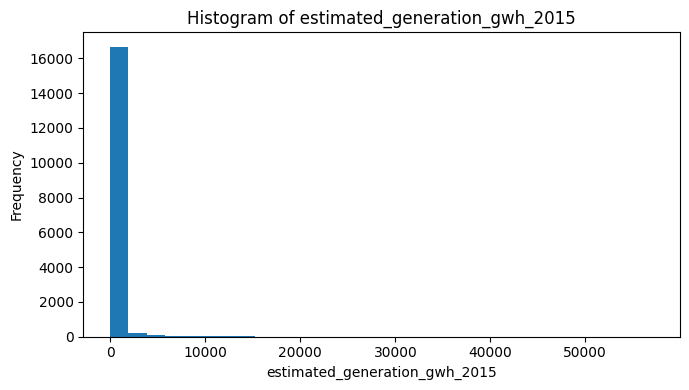

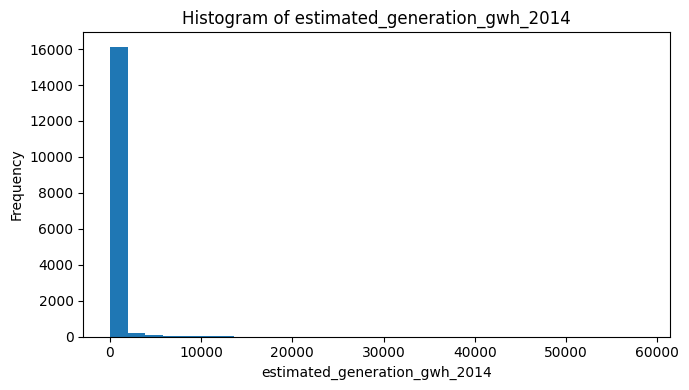

In [ ]:
step11_histograms(df, numeric_cols, max_plots=8, bins=30)

<Figure size 1000x1000 with 0 Axes>

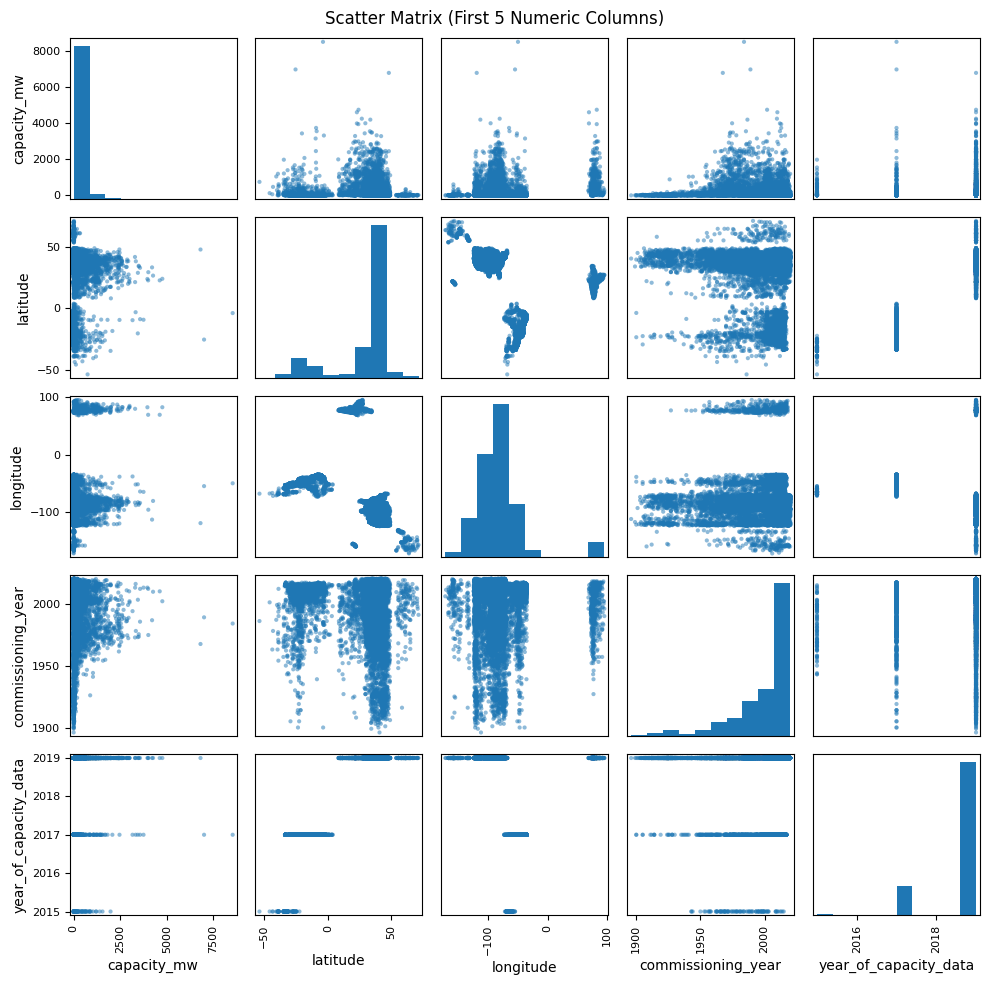

In [ ]:
step12_scatter_matrix(df, numeric_cols, k=5)

In [ ]:
step13_save_artifacts(schema_df, numeric_summary, outlier_df, corr_df)

NameError: name 'schema_df' is not defined

✅ BIVARIATE ANALYSIS (MOST IMPORTANT FOR POWER PLANT DATA)

These are the 6 most essential relationships to explore:

1. Capacity vs Generation (core performance metric)
2. Capacity vs Primary Fuel (operational efficiency differences)
3. Latitude/Longitude vs Capacity (geospatial patterns)
4. Year-wise Generation correlations (2013–2018 trends)
5. Country vs Generation (national energy mix)
6. Owner vs Capacity (market concentration)

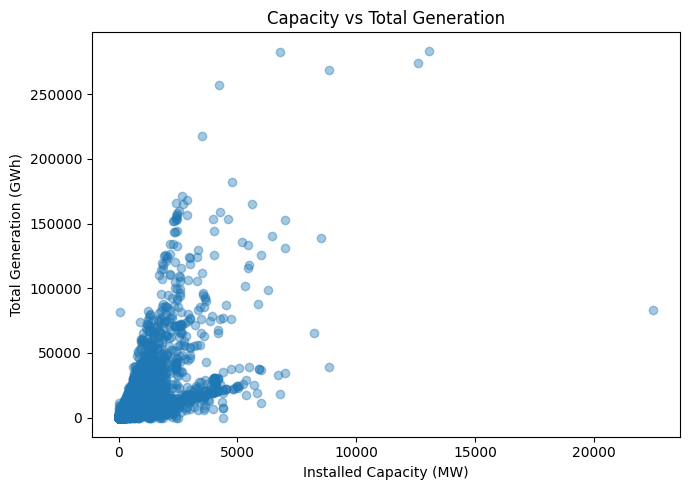

In [ ]:
#Capacity vs Generation (core performance metric)
df["total_gen"] = (
    df[[c for c in df.columns if "generation_gwh" in c.lower()]]
    .sum(axis=1, skipna=True)
)

plt.figure(figsize=(7,5))
plt.scatter(df["capacity_mw"], df["total_gen"], alpha=0.4)
plt.xlabel("Installed Capacity (MW)")
plt.ylabel("Total Generation (GWh)")
plt.title("Capacity vs Total Generation")
plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

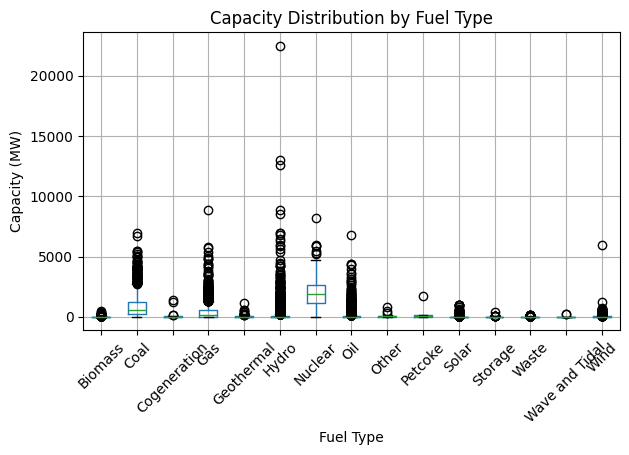

In [ ]:
#Capacity vs Primary Fuel (operational efficiency differences)
fuel_cap = df[["primary_fuel", "capacity_mw"]].dropna()

plt.figure(figsize=(8,5))
fuel_cap.boxplot(by="primary_fuel", column="capacity_mw", rot=45)
plt.xlabel("Fuel Type")
plt.ylabel("Capacity (MW)")
plt.title("Capacity Distribution by Fuel Type")
plt.suptitle("")
plt.tight_layout()
plt.show()


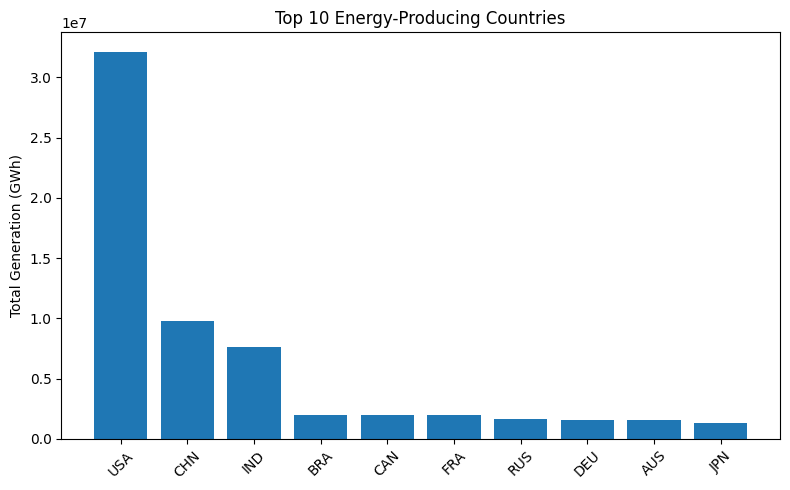

In [ ]:
#Country vs Generation (national energy mix)
country_gen = (
    df.groupby("country")["total_gen"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8,5))
plt.bar(country_gen.index, country_gen.values)
plt.xticks(rotation=45)
plt.ylabel("Total Generation (GWh)")
plt.title("Top 10 Energy-Producing Countries")
plt.tight_layout()
plt.show()


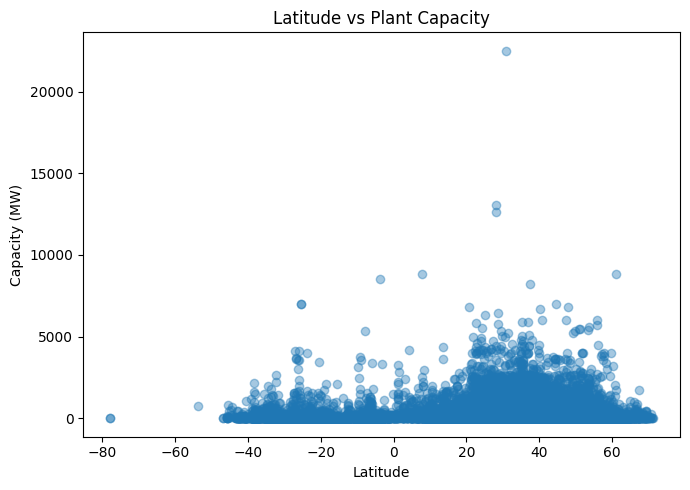

In [ ]:
#Scatter: Capacity vs Latitude (Regional Scaling Pattern)
plt.figure(figsize=(7,5))
plt.scatter(df["latitude"], df["capacity_mw"], alpha=0.4)
plt.xlabel("Latitude")
plt.ylabel("Capacity (MW)")
plt.title("Latitude vs Plant Capacity")
plt.tight_layout()
plt.show()


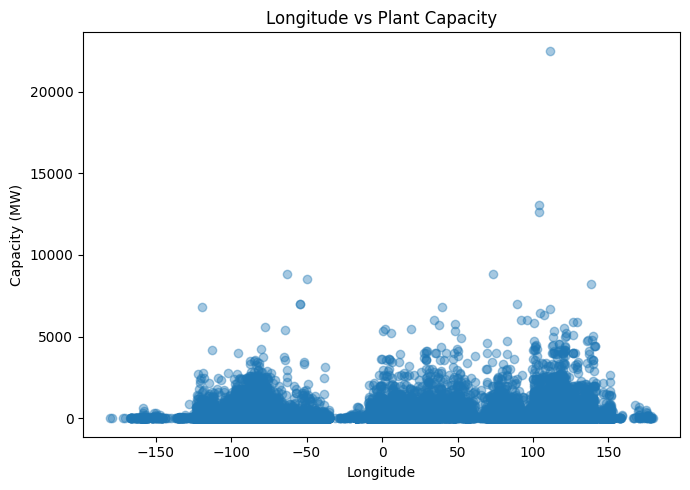

In [ ]:
#5. Scatter: Capacity vs Longitude
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.scatter(df["longitude"], df["capacity_mw"], alpha=0.4)
plt.xlabel("Longitude")
plt.ylabel("Capacity (MW)")
plt.title("Longitude vs Plant Capacity")
plt.tight_layout()
plt.show()


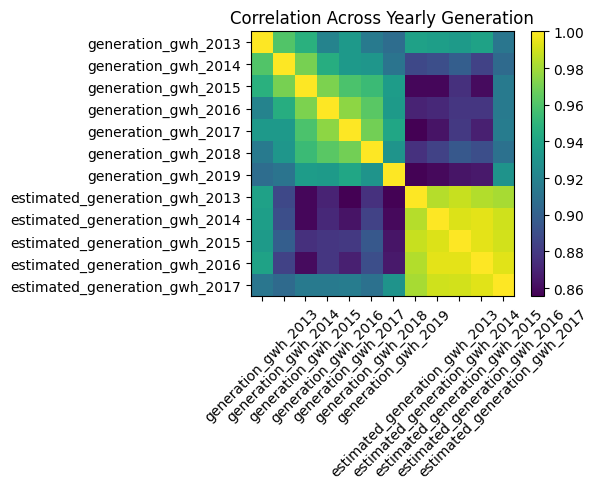

In [ ]:
#6. Heatmap: Year-to-Year Generation Correlation
year_cols = [c for c in df.columns if "generation_gwh" in c.lower()]

corr_years = df[year_cols].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr_years, interpolation="nearest", aspect="auto")
plt.title("Correlation Across Yearly Generation")
plt.xticks(ticks=range(len(year_cols)), labels=year_cols, rotation=45)
plt.yticks(ticks=range(len(year_cols)), labels=year_cols)
plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34936 entries, 0 to 34935
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country                         34936 non-null  object 
 1   country_long                    34936 non-null  object 
 2   name                            34936 non-null  object 
 3   gppd_idnr                       34936 non-null  object 
 4   capacity_mw                     34936 non-null  float64
 5   latitude                        34936 non-null  float64
 6   longitude                       34936 non-null  float64
 7   primary_fuel                    34936 non-null  object 
 8   other_fuel1                     1944 non-null   object 
 9   other_fuel2                     276 non-null    object 
 10  other_fuel3                     92 non-null     object 
 11  commissioning_year              17447 non-null  float64
 12  owner                           

In [ ]:
# --- Create total generation across years, safely ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If df not loaded:
# df = pd.read_csv("/mnt/data/power_plant_database_global.csv", low_memory=False)

# Detect yearly generation columns like generation_gwh_2013 ... 2019
gen_cols = [c for c in df.columns if c.lower().startswith("generation_gwh_")]

# Create a robust total generation column (skip NaNs)
if gen_cols:
    df["total_gen_gwh"] = df[gen_cols].sum(axis=1, skipna=True)
else:
    # If the dataset has no yearly generation columns, create a placeholder
    df["total_gen_gwh"] = np.nan

# Optional cleanups: standardize some typical column names if they exist
if "primary_fuel" not in df.columns:
    # Sometimes column names vary (e.g., 'fuel1' or 'fuel_type')
    for alt in ["fuel1", "fuel_type", "fuel"]:
        if alt in df.columns:
            df.rename(columns={alt: "primary_fuel"}, inplace=True)
            break

# Capacity column sanity
if "capacity_mw" not in df.columns:
    raise KeyError("Expected column 'capacity_mw' not found. Please adjust code to your capacity column name.")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34936 entries, 0 to 34935
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country                         34936 non-null  object 
 1   country_long                    34936 non-null  object 
 2   name                            34936 non-null  object 
 3   gppd_idnr                       34936 non-null  object 
 4   capacity_mw                     34936 non-null  float64
 5   latitude                        34936 non-null  float64
 6   longitude                       34936 non-null  float64
 7   primary_fuel                    34936 non-null  object 
 8   other_fuel1                     1944 non-null   object 
 9   other_fuel2                     276 non-null    object 
 10  other_fuel3                     92 non-null     object 
 11  commissioning_year              17447 non-null  float64
 12  owner                           

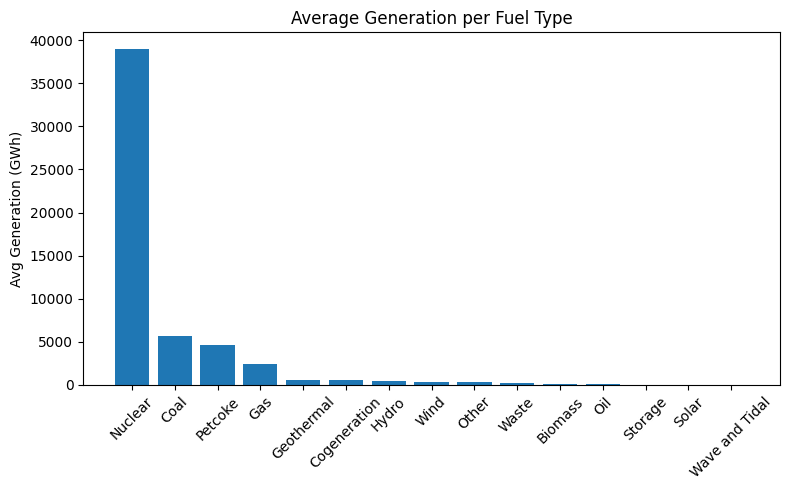

In [ ]:
#7. Fuel Type vs Average Generation
fuel_gen = df.groupby("primary_fuel")["total_gen_gwh"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
plt.bar(fuel_gen.index, fuel_gen.values)
plt.xticks(rotation=45)
plt.ylabel("Avg Generation (GWh)")
plt.title("Average Generation per Fuel Type")
plt.tight_layout()
plt.show()
